# 投资组合风险价值和条件风险价值

By Jonathan Larkin and Delaney Granizo-Mackenzie.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

风险价值(VaR)是投资组合风险管理中的一个关键概念。它使用过去观察到的投资组合收益分布来估计在不同可能性水平下你未来的损失。让我们通过一个示例来演示这个概念。

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
import time

import matplotlib.pyplot as plt

## 模拟数据的例子

让我们模拟10种假设资产的收益。

#### 请注意

我们用正态分布来模拟回报，实际上，真实回报几乎不会服从正态分布，通常会有一些奇怪的行为，包括肥尾。我们稍后将对此进行更多讨论。

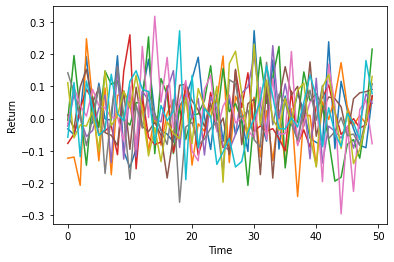

In [2]:
# mu = 0.01, std = 0.10, 1000 bars, 10 assets
mu = 0.01
sigma = 0.10
bars = 1000
num_assets = 10

returns = np.random.normal(mu, sigma, (bars, num_assets))

# Fake asset names
names = ['Asset %s' %i  for i in range(num_assets)]

# Put in a pandas dataframe
returns = pd.DataFrame(returns, columns=names)

# Plot the last 50 bars
plt.plot(returns.head(50))
plt.xlabel('Time')
plt.ylabel('Return');

覆盖$\alpha$的风险值(VaR)被定义为我们可能预期损失的最大金额，可能性为$p = 1 - \alpha$。换句话说，不超过$100 \times p \%$的天数，我们应该预期损失超过VaR。有许多方法来估计VaR，但没有一种是完美的。事实上，你不应该完全相信VaR，它的目的是为了了解在不同程度的极端情况下可能会损失多少，并将这些信息提供给负责风险管理的人。

高$\alpha$的VaR是最坏情况结果的度量。例如，可以跟踪他们的$\alpha = 0.999$ VaR，以了解1/1000危机事件如何影响他们。由于实际分布往往是发散的，而且随着我们沿着尾部走得越来越远，分布的一致性也越来越差，所以我们应该对极端的VaR持保留态度。

### 与置信区间的关系

对于那些熟悉置信区间的人来说，VaR是非常相似的。试图用$\alpha$指定的间隔来覆盖一组可能的值的想法与VaR试图覆盖一组可能的损失的想法类似。对于不熟悉的人，有一个讲座[这里](https://www.quantopian.com/lectures/confidence-intervals).

### 历史(非参数)VaR

我们将使用历史VaR，它查看以前的回报分布并使用它来计算$p$百分比。假设未来收益与过去收益接近，这一百分位数就是你可以合理预期的概率为$p$的损失。同样，这也不是完美的，它要求不存在回报分布变化的制度变化。例如，如果你的历史窗口不包括任何危机事件，你的VaR估计将远远低于它应该。

要计算覆盖$\alpha$的历史VaR值，我们只需用最低的观测的报酬率的$100×(1 - \alpha)$百分位数，并将其乘以我们的总投资价值。

现在我们来计算这10项资产的VaR。为此，我们需要一组投资组合权重。我们从超级简单开始。

In [3]:
weights = np.ones((10, 1))
# Normalize
weights = weights / np.sum(weights)

In [4]:
def value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    returns = returns.fillna(0.0)
    # Multiply asset returns by weights to get one weighted portfolio return
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    # Compute the correct percentile loss and multiply by value invested
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

我们将为$\alpha = 0.95$计算VaR。

In [5]:
value_invested = 1000000

value_at_risk(value_invested, returns, weights, alpha=0.95)

-39439.42772500833

在解释这一点时，我们说，从历史上看，每天不超过$5\%$会导致比这更极端的损失，或者每天你损失这么多的概率小于$5\%$。记住，任何像这样的预测都只是一个估计。

## 正态与非参数的历史变量

### 正态的情况下

VaR的一个特殊情况是，您假设收益遵循一个给定的分布，而不是按照历史上的非参数引用它。在这种情况下，一个正常的VaR将适合我们的数据，因为我们所有的回报都是模拟成一个正态分布。我们可以使用正态分布累积分布函数(CDF)来验证这一点，该函数将一条正态曲线下的面积相加，从而计算出某些值的可能性。我们将使用逆CDF，或PPF，它将告诉我们该可能性对应于哪个值。

具体来说，正态VaR的封闭形式公式为

$$VaR_{\alpha}(x) = \mu - \sigma N^{-1}(\alpha)$$

In [6]:
# Portfolio mean return is unchanged, but std has to be recomputed
# This is because independent variances sum, but std is sqrt of variance
portfolio_std = np.sqrt( np.power(sigma, 2) * num_assets ) / num_assets

# manually 
(mu - portfolio_std * norm.ppf(0.95)) * value_invested

-42014.83878755574

看起来很接近随机方差。让我们想象一下连续的正态情况。注意，VaR表示为一个返回值，而不是一个绝对损失值。要得到一笔损失，我们只需乘以投资的价值。

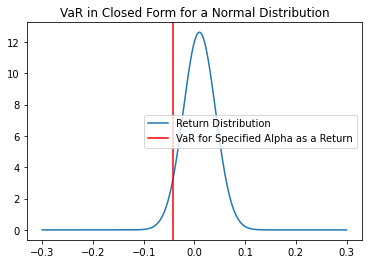

In [7]:
def value_at_risk_N(mu=0, sigma=1.0, alpha=0.95):
    return mu - sigma*norm.ppf(alpha)


x = np.linspace(-3*sigma,3*sigma,1000)
y = norm.pdf(x, loc=mu, scale=portfolio_std)
plt.plot(x,y);
plt.axvline(value_at_risk_N(mu = 0.01, sigma = portfolio_std, alpha=0.95), color='red', linestyle='solid');
plt.legend(['Return Distribution', 'VaR for Specified Alpha as a Return'])
plt.title('VaR in Closed Form for a Normal Distribution');

### 历史(非参数)

而历史VaR则使用历史数据来绘制离散概率密度函数，即直方图。然后找到只有$100 \times (1-\alpha)\%$的点在该返回值以下。它将该返回作为覆盖$\alpha$的VaR返回。

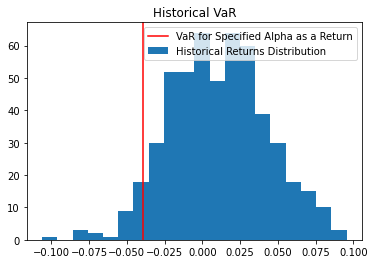

In [8]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

plt.hist(portfolio_returns.values, bins=20)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR');

### 基础分布并不总是正态的

在真实的金融数据中，潜在的分布很少是正态的。这就是为什么我们更喜欢历史的VaR，而不是一个潜在的分布假设。历史VaR也是非参数的，所以我们不会有将分布参数过度拟合到某些数据集的风险。

#### 真实数据的例子

我们将在一些真实的金融数据中展示这一点。

In [9]:
# OEX components as of 3/31/16
# http://www.cboe.com/products/indexcomponents.aspx?DIR=OPIndexComp&FILE=snp100.doc
oex = ['MMM','T','ABBV','ABT','ACN','ALL','GOOGL','GOOG','MO','AMZN','AXP','AIG','AMGN','AAPL','BAC',
       'BRK-B','BIIB','BLK','BA','BMY','CVS','COF','CAT','CELG','CVX','CSCO','C','KO','CL','CMCSA',
       'COP','DHR','DUK','DD','EMC','EMR','EXC','XOM','FB','FDX','F','GD','GE','GM','GILD',
       'GS','HAL','HD','HON','INTC','IBM','JPM','JNJ','KMI','LLY','LMT','LOW','MA','MCD','MDT','MRK',
       'MET','MSFT','MON','MS','NKE','NEE','OXY','ORCL','PYPL','PEP','PFE','PM','PG','QCOM',
       'RTN','SLB','SPG','SO','SBUX','TGT','TXN','BK','TWX','USB','UNP','UPS','UTX',
       'UNH','VZ','V','WMT','WBA','DIS','WFC']
tickers = oex
num_stocks = len(tickers)

In [ ]:
import yfinance as yf
start = time.time()
data = yf.download(tickers,'2014-01-01','2016-04-04')['Close']
end = time.time()
print ("Time: %0.2f seconds." % (end - start))

[***                    6%                       ]  6 of 95 completed

Exception in thread Thread-7:
Traceback (most recent call last):
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 662, in urlopen
    self._prepare_proxy(conn)
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 948, in _prepare_proxy
    conn.connect()
  File "d:\python\lib\site-packages\urllib3\connection.py", line 360, in connect
    ssl_context=context,
  File "d:\python\lib\site-packages\urllib3\util\ssl_.py", line 370, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "d:\python\lib\ssl.py", line 423, in wrap_socket
    session=session
  File "d:\python\lib\ssl.py", line 870, in _create
    self.do_handshake()
  File "d:\python\lib\ssl.py", line 1139, in do_handshake
    self._sslobj.do_handshake()
OSError: [Errno 0] Error

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\python\lib\site-packages\requests\adapters.py", line 449, in s

[***                    7%                       ]  7 of 95 completed

Exception in thread Thread-14:
Traceback (most recent call last):
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 662, in urlopen
    self._prepare_proxy(conn)
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 948, in _prepare_proxy
    conn.connect()
  File "d:\python\lib\site-packages\urllib3\connection.py", line 360, in connect
    ssl_context=context,
  File "d:\python\lib\site-packages\urllib3\util\ssl_.py", line 370, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "d:\python\lib\ssl.py", line 423, in wrap_socket
    session=session
  File "d:\python\lib\ssl.py", line 870, in _create
    self.do_handshake()
  File "d:\python\lib\ssl.py", line 1139, in do_handshake
    self._sslobj.do_handshake()
OSError: [Errno 0] Error

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\python\lib\site-packages\requests\adapters.py", line 449, in 

[****                   8%                       ]  8 of 95 completed

Exception in thread Thread-15:
Traceback (most recent call last):
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 662, in urlopen
    self._prepare_proxy(conn)
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 948, in _prepare_proxy
    conn.connect()
  File "d:\python\lib\site-packages\urllib3\connection.py", line 360, in connect
    ssl_context=context,
  File "d:\python\lib\site-packages\urllib3\util\ssl_.py", line 370, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "d:\python\lib\ssl.py", line 423, in wrap_socket
    session=session
  File "d:\python\lib\ssl.py", line 870, in _create
    self.do_handshake()
  File "d:\python\lib\ssl.py", line 1139, in do_handshake
    self._sslobj.do_handshake()
OSError: [Errno 0] Error

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\python\lib\site-packages\requests\adapters.py", line 449, in 

[*****************     35%                       ]  33 of 95 completed

Exception in thread Thread-46:
Traceback (most recent call last):
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 662, in urlopen
    self._prepare_proxy(conn)
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 948, in _prepare_proxy
    conn.connect()
  File "d:\python\lib\site-packages\urllib3\connection.py", line 360, in connect
    ssl_context=context,
  File "d:\python\lib\site-packages\urllib3\util\ssl_.py", line 370, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "d:\python\lib\ssl.py", line 423, in wrap_socket
    session=session
  File "d:\python\lib\ssl.py", line 870, in _create
    self.do_handshake()
  File "d:\python\lib\ssl.py", line 1139, in do_handshake
    self._sslobj.do_handshake()
ConnectionResetError: [WinError 10054] 远程主机强迫关闭了一个现有的连接。

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\python\lib\site-packages\requ

[**********************71%*********              ]  67 of 95 completed

Exception in thread Thread-81:
Traceback (most recent call last):
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 376, in _make_request
    self._validate_conn(conn)
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 994, in _validate_conn
    conn.connect()
  File "d:\python\lib\site-packages\urllib3\connection.py", line 360, in connect
    ssl_context=context,
  File "d:\python\lib\site-packages\urllib3\util\ssl_.py", line 370, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "d:\python\lib\ssl.py", line 423, in wrap_socket
    session=session
  File "d:\python\lib\ssl.py", line 870, in _create
    self.do_handshake()
  File "d:\python\lib\ssl.py", line 1139, in do_handshake
    self._sslobj.do_handshake()
TimeoutError: [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。

During handling of the

[**********************72%**********             ]  68 of 95 completed

Exception in thread Thread-84:
Traceback (most recent call last):
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 376, in _make_request
    self._validate_conn(conn)
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 994, in _validate_conn
    conn.connect()
  File "d:\python\lib\site-packages\urllib3\connection.py", line 360, in connect
    ssl_context=context,
  File "d:\python\lib\site-packages\urllib3\util\ssl_.py", line 370, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "d:\python\lib\ssl.py", line 423, in wrap_socket
    session=session
  File "d:\python\lib\ssl.py", line 870, in _create
    self.do_handshake()
  File "d:\python\lib\ssl.py", line 1139, in do_handshake
    self._sslobj.do_handshake()
TimeoutError: [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。

During handling of the

[**********************88%*****************      ]  84 of 95 completed

Exception in thread Thread-82:
Traceback (most recent call last):
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 376, in _make_request
    self._validate_conn(conn)
  File "d:\python\lib\site-packages\urllib3\connectionpool.py", line 994, in _validate_conn
    conn.connect()
  File "d:\python\lib\site-packages\urllib3\connection.py", line 360, in connect
    ssl_context=context,
  File "d:\python\lib\site-packages\urllib3\util\ssl_.py", line 370, in ssl_wrap_socket
    return context.wrap_socket(sock, server_hostname=server_hostname)
  File "d:\python\lib\ssl.py", line 423, in wrap_socket
    session=session
  File "d:\python\lib\ssl.py", line 870, in _create
    self.do_handshake()
  File "d:\python\lib\ssl.py", line 1139, in do_handshake
    self._sslobj.do_handshake()
TimeoutError: [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。

During handling of the

In [ ]:
returns = data.pct_change(1:)
returns = returns - returns.mean(skipna=True) # de-mean the returns

data.plot(legend=None);
returns.plot(legend=None); 

现在我们需要生成一些权值。

In [ ]:
def scale(x):
    return x / np.sum(np.abs(x))

weights = scale(np.random.random(num_stocks))
plt.bar(np.arange(num_stocks),weights);

现在让我们计算$\alpha = 0.95$的VaR。从现在开始，我们将把它写成$VaR_{\alpha=0.95}$。

In [ ]:
value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520)

我们把它可视化。

In [ ]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

plt.hist(portfolio_returns, bins=20)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

这个分布看起来明显是不正态的，但是让我们用一个统计检验来确认它是不是不正常的。我们用Jarque-Bera, p值截止值是0。05。

In [ ]:
from statsmodels.stats.stattools import jarque_bera

_, pvalue, _, _ = jarque_bera(portfolio_returns)

if pvalue > 0.05:
    print( 'The portfolio returns are likely normal.')
else:
    print ('The portfolio returns are likely not normal.')

当然，它们很可能不是正态分布，所以用正态分布作为VaR计算的基础是一个很大的错误。

## 我们在非参数上撒谎了

你会注意到VaR计算明显地使用了一个回望窗口。这是一个参数，否则“非参数”的历史变量。请记住，因为回望窗口会影响VaR，所以选择一个回望窗口的长度足以使VaR收敛是很重要的。为了检查我们的值是否已经收敛，让我们做一个实验。

还要记住的是，即使某件事集中在500天窗口内，也可能忽略了1000天前发生的金融崩溃，因此忽略了关键数据。另一方面，由于返回变量的非平稳性，使用所有时间数据可能是无用的。基本上，当返回的方差随时间变化时，较老的测量可能反映不再准确的状态。要了解更多关于非平稳性的信息，你可以查看[这堂课](https://www.quantopian.com/lectures/integration-cointegration-and-stationarity).

In [ ]:
N = 1000
VaRs = np.zeros((N, 1))
for i in range(N):
    VaRs[i] = value_at_risk(value_invested, returns, weights, lookback_days=i)

plt.plot(VaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

我们可以看到VaR在400-600个回望窗口期内确实收敛。因此我们的520天的参数应该是好的。实际上，1000可能更好，因为它使用了更多的信息，但计算更密集，而且容易受到平稳性问题的影响。

在评估VaR是否有意义时，做这样的分析是很有用的。我们要做的另一个检查是在这段时间内投资组合回报的平稳性。

In [ ]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(portfolio_returns)
pvalue = results[1]

if pvalue < 0.05:
    print( 'Process is likely stationary.')
else:
    print('Process is likely non-stationary.') 

## 条件风险值(CVaR)

许多人认为CVaR是对VaR的一种改进，因为它考虑了收益分布的形状。它也被称为预期亏空(ES)，因为它是对所有不同的可能损失大于VaR和它们相应的估计概率的期望。

如果你不熟悉期望，很多内容可以在网上找到。不过，我们将提供一个简短的复习。

### 期望值

假设你有一个公平的六面骰子。每个数都是等可能的。期望的概念，写成$\mathrm{E}(X)$，是您应该期望从所有可能的结果中得到的结果。为了得到这个，你把每个事件乘以那个事件的概率然后把它们加起来，把它想成概率加权平均值。有了骰子

$$1/6 \times 1 + 1/6 \times 2 + 1/6 \times 3 + 1/6 \times 4 + 1/6 \times 5 + 1/6 \times 6 =  3.5$$

当概率不相等时，情况会变得更复杂，当结果是连续的，我们必须使用封闭形式的积分方程。这是CVaR的公式。

$$CVaR_{\alpha}(x) \approx \frac{1}{(1-\alpha)} \int_{f(x,y) \geq VaR_{\alpha}(x)} f(x,y)p(y)dy dx$$

In [ ]:
def cvar(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    # Call out to our existing function
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    # Get back to a return rather than an absolute loss
    var_pct_loss = var / value_invested
    
    return value_invested * np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss])

让我们在数据上计算CVaR，看看它与VaR的比较。

In [ ]:
cvar(value_invested, returns, weights, lookback_days=500)

In [ ]:
value_at_risk(value_invested, returns, weights, lookback_days=500)

CVaR值更高，因为它捕获了更多关于分布形状的信息，也就是分布的矩。如果尾巴有更多的质量，这个就会抓住它。一般来说，与VaR相比，它被认为是一个更好的度量标准，在大多数情况下，你应该使用它而不是VaR。

让我们可视化一下它捕捉到了什么。

In [ ]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_CVaR_return = portfolio_CVaR / value_invested

# Plot only the observations > VaR on the main histogram so the plot comes out
# nicely and doesn't overlap.
plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=10)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed');
plt.legend(['VaR for Specified Alpha as a Return',
            'CVaR for Specified Alpha as a Return',
            'Historical Returns Distribution', 
            'Returns < VaR'])
plt.title('Historical VaR and CVaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

### 再次检查收敛性

最后，检查收敛性。

In [ ]:
N = 1000
CVaRs = np.zeros((N, 1))
for i in range(N):
    CVaRs[i] = cvar(value_invested, returns, weights, lookback_days=i)

plt.plot(CVaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

# 参考

 * http://www.wiley.com/WileyCDA/WileyTitle/productCd-1118445597.html
 * http://www.ise.ufl.edu/uryasev/publications/
 * http://www.ise.ufl.edu/uryasev/files/2011/11/VaR_vs_CVaR_CARISMA_conference_2010.pdf
 * http://faculty.washington.edu/ezivot/econ589/me20-1-4.pdf